In [48]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

In [49]:
# kaggle competition https://www.kaggle.com/c/shelter-animal-outcomes/data

In [50]:
# we will take train dataset from Kaggle and split it into train/ test (we cannot use test dataset from Kaggle
# since it has no labels)
all_data = pd.read_csv("../shelter-animal-outcomes/train.csv")

In [51]:
all_data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [52]:
all_data.shape

(26729, 10)

In [53]:
all_data.OutcomeType.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [54]:
all_data.isna().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

In [55]:
all_data['SexuponOutcome'] =all_data['SexuponOutcome'].fillna("Neutered Male")

In [56]:
del all_data["AnimalID"]
del all_data["OutcomeSubtype"]

In [57]:
# make a column if the name is known or not
all_data['Name'] =all_data['Name'].fillna(0)
all_data.loc[all_data['Name'] != 0, "Name"] = 1

all_data.loc[all_data["AnimalType"]== "Dog", "AnimalType"] = 1
all_data.loc[all_data["AnimalType"]!= 1, "AnimalType"] = 0

In [58]:
# Let's create "Day_of_week" and "Hour" columns:
all_data['Hour'] = all_data.DateTime.map( lambda x: pd.to_datetime(x).hour )
all_data['Day_of_Week'] = all_data.DateTime.map( lambda x: pd.to_datetime(x).dayofweek )

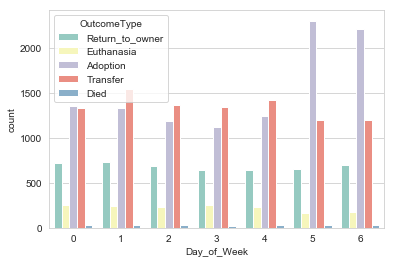

In [59]:
import seaborn as sns
%matplotlib inline

sns.countplot(data=all_data, x='Day_of_Week',hue="OutcomeType", palette = "Set3")

In [60]:
# "5" and "6" means "Suturday" and "Sunday". The animals are more likely adopted at Weekends! 
# Thus, I am replacing 5 and 6 by 1, and other numbers by 0
all_data.loc[all_data["Day_of_Week"]== 5, "Day_of_Week"] = 10
all_data.loc[all_data["Day_of_Week"]== 6, "Day_of_Week"] = 10
all_data.loc[all_data["Day_of_Week"]!= 10, "Day_of_Week"] = 0
all_data.loc[all_data["Day_of_Week"]== 10, "Day_of_Week"] = 1

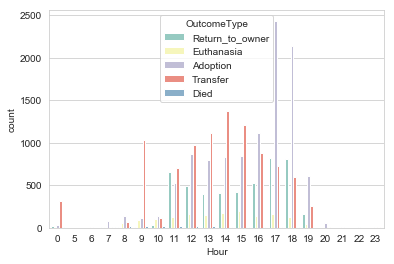

In [61]:
sns.countplot(data=all_data, x='Hour',hue="OutcomeType", palette = "Set3")

It is interesting! The animal are adopted more likely at 16-19 and 7-8; transfered at 0, 9, 12-15. Thus, I am going to create features: 16and19, 17and18, 7and8, 9, 0, 12and13, 14and15, other_time.

In [62]:
def day(x):
    if x == 16 or x == 19:
        x = "16and19"
    elif x == 17 or x == 18:
        x = "17and18"
    elif x == 7 or x == 8:
        x = "7and8"
    elif x == 12 or x == 13:
        x = "12and13"
    elif x == 14 or x == 15:
        x = "14and15"
    elif x == 9:
        x = "9"
    elif x == 0:
        x = "0"
    else:
        x = "other_time"
    return x
       
all_data['Hour'] = all_data.Hour.apply(day)

In [63]:
def age_as_float(x):
    x = str(x)
    x_list = x.split(" ")
    if len(x_list)==2:
        if x_list[1] =='year': return 1.0
        elif x_list[1] =='years': return float(x_list[0])
        elif x_list[1] =='month': return float(x_list[0])/12
        elif x_list[1] =='months': return float(x_list[0])/12
        elif x_list[1] =='week': return float(x_list[0])
        elif x_list[1] =='weeks': return float(x_list[0])/54
        elif x_list[1] =='days': return float(x_list[0])/365
        else: return 0
    else:return 0

all_data['AgeuponOutcome'] = all_data.AgeuponOutcome.apply(age_as_float)
#now we have 0 age for the animals with undefined age. Let's replace 0 by mean age:
all_data.loc[all_data['AgeuponOutcome']== 0, "AgeuponOutcome"] = all_data['AgeuponOutcome'].median()

In [64]:
#I used tutorial from https://www.dataquest.io/learn
def create_dummies(var):
    var_unique = var.unique()
    var_unique.sort()
    dummy = pd.DataFrame()
    for val in var_unique:
    #for val in var_unique[:-1]:
        # which columns are equal to our unique value
        d = var == val
        # make a new column with a dummy variable
        dummy[var.name + "_" + str(val)] = d.astype(int)
    return(dummy)

sex_dummies = create_dummies(all_data["SexuponOutcome"])
data = pd.concat([all_data, sex_dummies], axis=1)
del all_data["SexuponOutcome"]

hour = create_dummies(all_data["Hour"])
all_data = pd.concat([all_data, hour], axis=1)
del all_data["Hour"]

In [65]:
items_counts = data['Breed'].value_counts()
# we are going to work with breeds with count > 150. Also, I am going to add "Boxer" and "Pit Bull" to my list since this dogs can be agressive.

In [66]:
to_my_breads = all_data['Breed'].value_counts() > 150

In [67]:
items_counts[to_my_breads]

Domestic Shorthair Mix       8810
Pit Bull Mix                 1906
Chihuahua Shorthair Mix      1766
Labrador Retriever Mix       1363
Domestic Medium Hair Mix      839
German Shepherd Mix           575
Domestic Longhair Mix         520
Siamese Mix                   389
Australian Cattle Dog Mix     367
Dachshund Mix                 318
Boxer Mix                     245
Miniature Poodle Mix          233
Border Collie Mix             229
Australian Shepherd Mix       163
Catahoula Mix                 157
Rat Terrier Mix               157
Name: Breed, dtype: int64

In [68]:
my_breeds = ["Domestic Shorthair", "Chihuahua Shorthair", "Labrador Retriever", 
             "Domestic Medium Hair", "German Shepherd", "Domestic Longhair", "Siamese", "Australian Cattle Dog", 
             "Dachshund", "Miniature Poodle", "Border Collie","Australian Shepherd", "Rat Terrier", "Catahoula", 
              "Husky", "Rottweiler", "Bulldog", "Pit Bull", "Boxer"]

In [69]:
import re
def breeds(x):
    x = str(x)
    breed = "other"
    for b in my_breeds:
        if re.search(b, x):
            breed = b
    return breed
all_data['My_Breeds'] = all_data.Breed.apply(breeds)

In [70]:
breed_dummies = create_dummies(all_data["My_Breeds"])
all_data = pd.concat([all_data, breed_dummies], axis=1)
del all_data["My_Breeds"]
del all_data["Breed"]

In [71]:
features = all_data.columns.tolist() 
print(features)

['Name', 'DateTime', 'OutcomeType', 'AnimalType', 'AgeuponOutcome', 'Color', 'Day_of_Week', 'Hour_0', 'Hour_12and13', 'Hour_14and15', 'Hour_16and19', 'Hour_17and18', 'Hour_7and8', 'Hour_9', 'Hour_other_time', 'My_Breeds_Australian Cattle Dog', 'My_Breeds_Australian Shepherd', 'My_Breeds_Border Collie', 'My_Breeds_Boxer', 'My_Breeds_Bulldog', 'My_Breeds_Catahoula', 'My_Breeds_Chihuahua Shorthair', 'My_Breeds_Dachshund', 'My_Breeds_Domestic Longhair', 'My_Breeds_Domestic Medium Hair', 'My_Breeds_Domestic Shorthair', 'My_Breeds_German Shepherd', 'My_Breeds_Husky', 'My_Breeds_Labrador Retriever', 'My_Breeds_Miniature Poodle', 'My_Breeds_Pit Bull', 'My_Breeds_Rat Terrier', 'My_Breeds_Rottweiler', 'My_Breeds_Siamese', 'My_Breeds_other']


In [72]:
features.remove("DateTime")
features.remove("OutcomeType")
features.remove("Color")

In [73]:
# random shift
all_data = all_data.sample(frac=1)

In [74]:
all_data.to_csv("dataset2.csv")